In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import math
from datetime import datetime
import matplotlib.animation as animation
from PIL import Image
import random
import pandas as pd

In [2]:
epsilon = math.ulp(1.0)

def softmax(x):
    return np.nan_to_num((np.exp(x)+epsilon))/np.nan_to_num((sum(np.exp(x))+epsilon))

def simulate_allstarts(eta,simlen,beta,a,h,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_log=np.zeros([simlen,P,N])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        for t in range(simlen):
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            x_log[t,start_node,:]=x
            m_log[t,start_node,:]=m
        x_last[:,start_node]=x
    autocorr = np.corrcoef(x_last.T) #correlation between attractors

    return (autocorr, m_log, x_log)

def simulate_allstarts_freq(eta,simlen,beta,a,h,freq,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        stim_node=start_node-freq
        for t in range(simlen):
            if (t>1) & (t%freq==0):
                x+=xi[:,stim_node%P]+0.0
                stim_node-=freq
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            m_log[t,:,:]=m
        x_last[:,start_node]=x
    cor_activity=np.corrcoef(x_last.T) #correlation between attractors
    return (m_log, cor_activity)

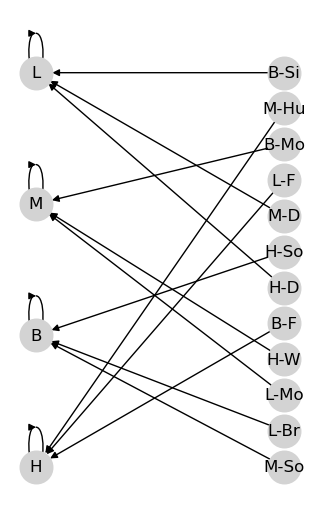

In [3]:
df = pd.read_csv('family-tree-adjacency-matrix.csv')
df = df.set_index(df.columns[0])

G_automata = nx.DiGraph()
G_automata.add_nodes_from(list(df.keys()))

for i in G_automata.nodes():
    for j in df[df[i].notnull()].index.tolist():
        G_automata.add_edge(i,j)
        
plt.figure(3,figsize=(3,5)) 
nx.draw(G_automata, pos=nx.bipartite_layout(G_automata, ['H','M','B','L']), with_labels=True, 
        node_size=550, node_color='lightgray')#, font_weight='normal')
# plt.savefig("family_tree_graph.pdf", format="pdf", bbox_inches="tight")

In [4]:
P = len(G_automata.nodes()) # number of patterns
N = 1000 # number of neurons
H = nx.adjacency_matrix(G_automata).T # adjacency matrix

char_ratio = 0.25
char_N = round(char_ratio*N)
rel_N = 1-char_N

homer = np.random.rand(N)
marge = np.random.rand(N)
bart = np.random.rand(N)
lisa = np.random.rand(N)

brother = np.random.rand(N)
sister = np.random.rand(N)
mother = np.random.rand(N)
father = np.random.rand(N)
son = np.random.rand(N)
daughter = np.random.rand(N)
husband = np.random.rand(N)
wife = np.random.rand(N)

homer_wife = np.concatenate([homer[:char_N-1],wife[:rel_N]])
homer_son = np.concatenate([homer[:char_N-1],son[:rel_N]])
homer_daughter = np.concatenate([homer[:char_N-1],daughter[:rel_N]])

marge_husband = np.concatenate([marge[:char_N-1],husband[:rel_N]])
marge_son = np.concatenate([marge[:char_N-1],son[:rel_N]])
marge_daughter = np.concatenate([marge[:char_N-1],daughter[:rel_N]])

lisa_father = np.concatenate([lisa[:char_N-1],father[:rel_N]])
lisa_mother = np.concatenate([lisa[:char_N-1],mother[:rel_N]])
lisa_brother = np.concatenate([lisa[:char_N-1],brother[:rel_N]])

bart_father = np.concatenate([bart[:char_N-1],father[:rel_N]])
bart_mother = np.concatenate([bart[:char_N-1],mother[:rel_N]])
bart_sister = np.concatenate([bart[:char_N-1],sister[:rel_N]])

# 'H', 'H-W', 'H-So', 'H-D', 'M', 'M-Hu', 'M-So', 'M-D', 'L', 'L-Mo', 'L-F', 'L-Br', 'B', 'B-Mo', 'B-F', 'B-Si'
xi = np.vstack((homer, homer_wife, homer_son, homer_daughter,
          marge, marge_husband, marge_son, marge_daughter,
          lisa, lisa_mother, lisa_father, lisa_brother,
          bart, bart_mother, bart_father, bart_sister)).T

xi_mean=np.sum(xi, axis=1, keepdims=True)/P
xi_bias=xi-xi_mean

In [5]:
simlen = 100
start_node = 1
a=0
h=1

beta = 1
eta = 0.1
noise = 0

m_log=np.zeros([simlen,P,P])
x_log=np.zeros([simlen,P,N])
x_last=np.zeros([N,P])

projection=((a*xi)+(h*(xi@H))).T # auto+hetero
for start_node in range(P):
    x=np.copy(xi[:,start_node])
    for t in range(simlen):
        r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
        r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
        x+=eta*(r[0]-x)
        m=np.zeros(P)
        for i in range(P):
            m[i] = np.corrcoef(x,xi[:,i])[0,1]
        x_log[t,start_node,:]=x
        m_log[t,start_node,:]=m
    x_last[:,start_node]=x

autocorr = np.corrcoef(x_last.T) #correlation between attractors

In [ ]:
node_labels = np.array(['H', 'H-W', 'H-So', 'H-D', 'M', 'M-Hu', 'M-So', 'M-D', 'L', 
                        'L-Mo', 'L-F', 'L-Br', 'B', 'B-Mo', 'B-F', 'B-Si'])
fig, axes = plt.subplots(nrows=math.ceil(P/4), ncols=4, figsize=(9,9))

axes = axes.flatten()
for i in range(0,P):
    axes[i].plot(m_log[:,i,:], label=node_labels)
    if (i % 4 == 0):
        axes[i].set_ylabel('Pattern overlap')
    if (i >= 12):
        axes[i].set_xlabel('$t$')

plt.tight_layout()
axes[7].legend(bbox_to_anchor=(1.1, 0.85),loc='upper left', borderaxespad=0.)
# plt.savefig("automata_a0_h1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
simlen=400

a=0
h=1

beta = 0.5
eta = 0.1
noise = 0

m_log=np.zeros([simlen,P,P])
x_log=np.zeros([simlen,P,N])
x_last=np.zeros([N,P])

projection=((a*xi)+(h*(xi@H))).T # auto+hetero
x=marge
for t in range(0,100):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log[t,0,:]=m
x = np.concatenate([np.copy(x)[:char_N-1],daughter[:rel_N]])
for t in range(100,200):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],daughter[:rel_N]])
for t in range(200,300):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],brother[:rel_N]])
for t in range(300,400):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log[t,0,:]=m

In [ ]:
simlen=400

a=0
h=1

beta = 0.5
eta = 0.1
noise = 0

m_log2=np.zeros([simlen,P,P])
x_log=np.zeros([simlen,P,N])
x_last=np.zeros([N,P])

projection=((a*xi)+(h*(xi@H))).T # auto+hetero
x=bart
for t in range(0,100):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log2[t,0,:]=m
x = np.concatenate([np.copy(x)[:char_N-1],father[:rel_N]])
for t in range(100,200):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log2[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],wife[:rel_N]])
for t in range(200,300):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log2[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],husband[:rel_N]])
for t in range(300,400):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log2[t,0,:]=m

In [ ]:
simlen=400

a=0
h=1

beta = 0.5
eta = 0.1
noise = 0

m_log3=np.zeros([simlen,P,P])
x_log=np.zeros([simlen,P,N])
x_last=np.zeros([N,P])

projection=((a*xi)+(h*(xi@H))).T # auto+hetero
x=homer
for t in range(0,100):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log3[t,0,:]=m
x = np.concatenate([np.copy(x)[:char_N-1],father[:rel_N]])
for t in range(100,200):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log3[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],son[:rel_N]])
for t in range(200,300):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log3[t,0,:]=m
x=np.concatenate([np.copy(x)[:char_N-1],mother[:rel_N]])
for t in range(300,400):
    r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
    r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
    x+=eta*(r[0]-x)
    m=np.zeros(P)
    for i in range(P):
        m[i] = np.corrcoef(x,xi[:,i])[0,1]
    x_log[t,0,:]=x
    m_log3[t,0,:]=m

In [ ]:
fig, axes = plt.subplots(3, ncols=1, figsize=(5,6))

axes = axes.flatten()
axes[0].plot(m_log[:,0,:], label=node_labels)
axes[1].plot(m_log2[:,0,:], label=node_labels)
axes[2].plot(m_log3[:,0,:], label=node_labels)
axes[2].set_xlabel("$t$")
axes[0].set_ylabel("Pattern overlap")
axes[1].set_ylabel("Pattern overlap")
axes[2].set_ylabel("Pattern overlap")

plt.tight_layout()
axes[0].legend(bbox_to_anchor=(1.02, 0.3),loc='upper left', borderaxespad=0.)
# plt.savefig("automata_a0_h1_over-time.pdf", format="pdf", bbox_inches="tight")
plt.show()